In [9]:
% matplotlib inline

import matplotlib.pyplot as plt
import seaborn
seaborn.set_style('white')

In [4]:
from glob import glob 
import os
import tqdm as tqdm 


import numpy as np
import scipy.ndimage


import sys
sys.path.append('../scripts')
import load_utils
import watereshed
import generator_3D

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [123]:
PATHS = {
    'DATA': '/home/ubuntu/data/DM_Data/RIII',
    'DESC': '/home/ubuntu/data/DM_Data/REPRISEIIISizes.xlsx'
}

In [163]:
patient_id = '1649R3019'
patient, meta = load_utils.load_patient(PATHS['DATA'], patient_id, metadata=True)
patient = np.flip(patient, 0)

meshs = glob(os.path.join(PATHS['DATA'], patient_id, '*_A.stl'))
meshs = load_utils.load_mesh(meshs[0], meta) 
meshs = np.flip(meshs, 0)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


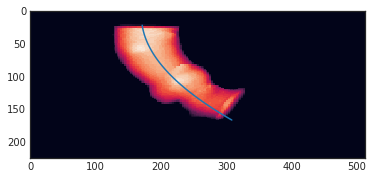

In [209]:
plt.imshow(meshs.sum(1))

x, y = np.asarray(np.where(meshs))[[0, 2]]
z = np.polyfit(x, y, 2)
p = np.poly1d(z)
xp = np.linspace(x.min(), x.max(), 100)
plt.plot(p(xp), xp, '-');

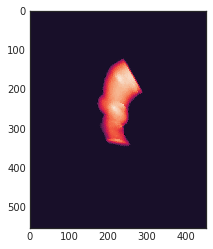

In [210]:
angle = np.arctan(p(x.max()) - p(x.max() + 1))
angle *= 180 / np.pi
angle = np.round(angle)
plt.imshow(scipy.ndimage.interpolation.rotate(meshs.sum(1), angle))

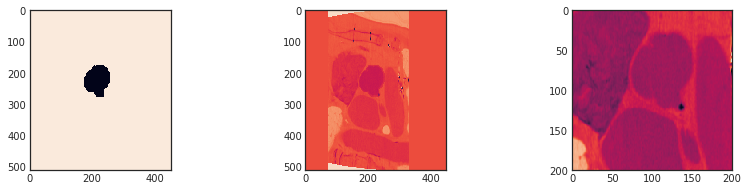

In [211]:
i = 240
# a = -50
mes = scipy.ndimage.interpolation.rotate(meshs[:, :512, :512], angle, (0, 2), mode='nearest', order=0)
pat = scipy.ndimage.interpolation.rotate(patient, angle, (0, 2))

plt.figure(figsize=(14, 10))
plt.subplot(331)
plt.imshow(~mes[i])
plt.subplot(332)
plt.imshow(-(pat[i] + 400 * mes[i, :pat.shape[1], :pat.shape[2]]))
plt.subplot(333)
plt.imshow(-(pat[i] + 0 * mes[i, :pat.shape[1], :pat.shape[2]])[150:350, 100:300])

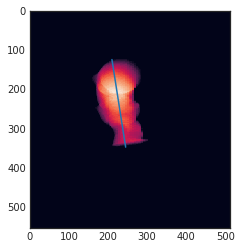

In [212]:
plt.imshow(mes.sum(2))
x, y = np.asarray(np.where(mes))[[0, 1]]
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
xp = np.linspace(x.min(), x.max(), 100)

angle = np.arctan(p(x.max()) - p(x.max() + 1))
angle *= 180 / np.pi
angle = np.round(angle)

plt.plot(p(xp), xp, '-');

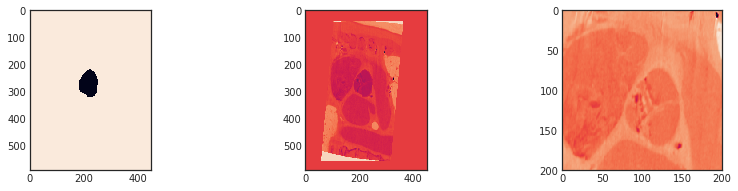

In [219]:
i = 290
# a = -50
# mes = scipy.ndimage.interpolation.rotate(mes[:, :pat.shape[1], :pat.shape[2]], angle, (0, 1), mode='nearest', order=0)
# pat = scipy.ndimage.interpolation.rotate(pat, angle, (0, 1))

plt.figure(figsize=(14, 10))
plt.subplot(331)
plt.imshow(~mes[i])
plt.subplot(332)
plt.imshow(-(pat[i] + 400 * mes[i, :pat.shape[1], :pat.shape[2]]))
plt.subplot(333)
plt.imshow(-(pat[i] + 0 * mes[i, :pat.shape[1], :pat.shape[2]])[150:350, 100:300])

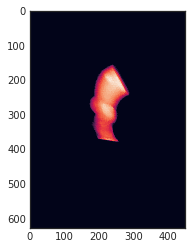

In [216]:
plt.imshow(mes.sum(1))

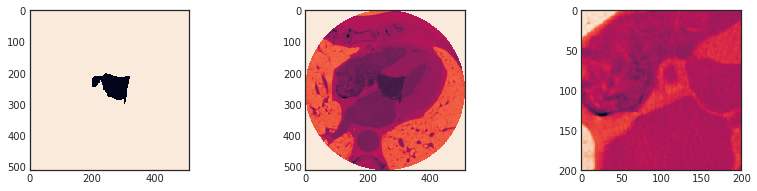

In [222]:
i = 140

plt.figure(figsize=(14, 10))
plt.subplot(331)
plt.imshow(~meshs[i])
plt.subplot(332)
plt.imshow(-(patient[i] + 400 * meshs[i, :512, :512]))
plt.subplot(333)
plt.imshow(-(patient[i])[150:350, 100:300])

In [13]:
import pandas as pd
from glob import glob

glob('../data/RII/0201RPII0/*')
df = pd.read_excel('../data/REPRISEIIISizes.xlsx')
df['Valve Size (Model number)'].value_counts()

25 mm    236
27 mm    236
23 mm    206
Name: Valve Size (Model number), dtype: int64

In [ ]:
croped = []
segmented = []
for i in tqdm(range(len(patient))):
    s, w = seperate_lungs(patient[i])
    croped.append(s)
    segmented.append(w)

croped = np.array(croped)
segmented = np.array(segmented)

In [65]:
# patient_id = '0201RPII019OMK'
# patient, meta = load_patient(patient_id, metadata=True)
# meshs = glob(os.path.join(PATHS['DATA'], patient_id, '*.stl'))
# meshs = [load_mesh(path, meta) for path in meshs]
# meshs = scipy.ndimage.label(meshs[1])[0] == 1
zss = np.array(np.where(meshs)).T

n = 7
cell_size = 100

cell = np.zeros(shape=(2, cell_size, cell_size))
maze = np.zeros(shape=(2, cell_size * n, cell_size * n))

frequency = 3 # one out of `frequency` will be positive
slices = np.random.choice(zss[:, 0], size=n ** 2)

zxy = np.zeros(shape=(3,), dtype=np.int16)

for i, zslice in enumerate(slices):
    if not np.random.randint(frequency):
        zxy = zss[zss[:, 0] == zslice]
        zxy = zxy[np.random.choice(len(zxy))]
    else:
        zxy[0] = zslice
        zxy[1:] = np.random.choice(patient.shape[-1], size=2)
        
    zxy[1:] = np.clip(zxy[1:] - cell_size // 2, 0, patient.shape[-1] - cell_size)
    cell[0] = patient[
        zxy[0], 
        zxy[1]: zxy[1] + cell_size, 
        zxy[2]: zxy[2] + cell_size
    ]
    cell[1] = mask[
        zxy[0], 
        zxy[1]: zxy[1] + cell_size, 
        zxy[2]: zxy[2] + cell_size
    ]
    if np.random.randint(2):
        np.flip(cell, axis=1)
    if np.random.randint(2):
        np.flip(cell, axis=2)
    maze[
        :,
        (i // n) * cell_size: (i // n + 1) * cell_size, 
        (i % n) * cell_size: (i % n + 1) * cell_size
    ] = cell.copy()


# for i in 

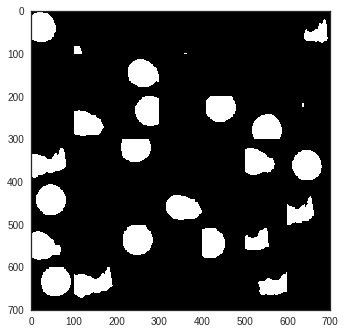

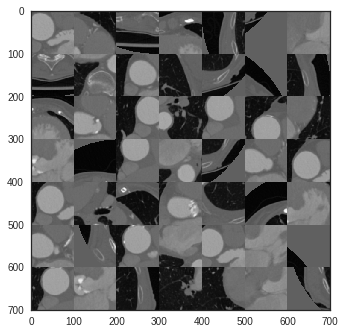

In [66]:
seaborn.set_style('white')
plt.imshow(-maze[1])
plt.show()
plt.imshow(-maze[0])
plt.show()